In [2]:
import os
import numpy as np
import struct
from numpy import zeros
import array
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import misc
import time
%matplotlib inline

In [3]:
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype='uint8')
    labels = zeros((N, 1), dtype='int8')
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return images, labels

In [4]:
tr,label = load_mnist("training")
tr_label = np.array(label,dtype = np.long)
te,te_label = load_mnist("testing")
te_label = np.array(te_label,dtype = np.long)

In [5]:
#scipy.misc.imread(d_tr)
def resize_data(dataset,size):
    rd = np.zeros((len(dataset),size,size))
    for img in range(len(dataset)):
        rd[img] = scipy.misc.imresize(dataset[img],(14,14))
    return rd

In [6]:
#resize the data set to 14*14
tr_14 = resize_data(tr,14)
te_14 = resize_data(te,14)

In [7]:
# import needed library for MLP 
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
from torch.autograd import Variable

In [8]:
# generalize
tr = tr/256
te = te/256
tr_14 = tr_14/256
te_14 = te_14/256

In [27]:
# import dataset yo torch dataloader
train_data =torch.utils.data.DataLoader(torch.from_numpy(tr),batch_size = 100)
test_data =torch.utils.data.DataLoader(torch.from_numpy(te),batch_size = 100)
train_data_14 = torch.utils.data.DataLoader(torch.from_numpy(tr_14),batch_size = 100)
test_data_14 = torch.utils.data.DataLoader(torch.from_numpy(te_14),batch_size = 100)
train_label =torch.from_numpy(tr_label)
test_label = torch.from_numpy(te_label)

In [28]:

#calculate accuracy
def accuracy(preb,label):
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(preb,1)==label)
    test_np = np.float32(test_np)
    return (100*np.mean(test_np))

In [56]:
#build MLP add dropout
num_drop = 0.4
class MLP_28_dropout(nn.Module):
    def __init__(self):
        super(MLP_28_dropout, self).__init__()
        self.L1 = nn.Linear(784,512)
        self.drop1 = nn.Dropout(num_drop)
        self.L2 = nn.Linear(512,128)
        self.drop2 = nn.Dropout(num_drop)
        self.L3 = nn.Linear(128,10)
    def forward(self,din):
        din = din.view(-1,28*28)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
# without dropout
class MLP_28(nn.Module):
    def __init__(self):
        super(MLP_28, self).__init__()
        self.L1 = nn.Linear(784,512)
        self.L2 = nn.Linear(512,128)
        self.L3 = nn.Linear(128,10)
    def forward(self,din):
        din = din.view(-1,28*28)
        dout = torch.nn.functional.relu(self.L1(din))
        dout = torch.nn.functional.relu(self.L2(dout))
        return torch.nn.functional.softmax(self.L3(dout))

In [57]:
#dropout 14*14
class MLP_14_dropout(nn.Module):
    def __init__(self):
        super(MLP_14_dropout, self).__init__()
        self.L1 = nn.Linear(196,128)
        self.drop1 = nn.Dropout(num_drop)
        self.L2 = nn.Linear(128,49)
        self.drop2 = nn.Dropout(num_drop)
        self.L3 = nn.Linear(49,10)

    def forward(self,din):
        din = din.view(-1,14*14)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
#without dropout 14*14
class MLP_14(nn.Module):
    def __init__(self):
        super(MLP_14, self).__init__()
        self.L1 = nn.Linear(196,128)
        self.L2 = nn.Linear(128,49)
        self.L3 = nn.Linear(49,10)

    def forward(self,din):
        din = din.view(-1,14*14)
        dout = torch.nn.functional.relu(self.L1(din))
        dout = torch.nn.functional.relu(self.L2(dout))
        return torch.nn.functional.softmax(self.L3(dout))

In [58]:
def train_28(input_data,input_label,momentum):
    model = MLP_28().cuda()
    sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
    lossfunc = torch.nn.CrossEntropyLoss()
    trace = []
    for n in range(50):
        sums = []
        for i,data in enumerate(input_data):
            sgd.zero_grad()
            data = data.type(torch.FloatTensor)
            labels = input_label[i*100:i*100+100].type(torch.LongTensor)
            inputs = torch.autograd.Variable(data).cuda()
            labels = torch.autograd.Variable(labels).cuda()
            outputs = model(inputs)
            loss = lossfunc(outputs,labels)
            loss.backward()
            sgd.step()
            sums.append(accuracy(outputs,labels))
        trace.append(sum(sums)/len(sums))
    return trace
def train_28_drop(input_data,input_label,momentum):
    model = MLP_28_dropout().cuda()
    sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
    lossfunc = torch.nn.CrossEntropyLoss()
    trace = []
    for n in range(50):
        sums = []
        for i,data in enumerate(input_data):
            sgd.zero_grad()
            data = data.type(torch.FloatTensor)
            labels = input_label[i*100:i*100+100].type(torch.LongTensor)
            inputs = torch.autograd.Variable(data).cuda()
            labels = torch.autograd.Variable(labels).cuda()
            outputs = model(inputs)
            loss = lossfunc(outputs,labels)
            loss.backward()
            sgd.step()
            sums.append(accuracy(outputs,labels))
        trace.append(sum(sums)/len(sums))
    return trace

In [59]:
def train_14_drop(input_data,input_label,momentum):
    model = MLP_14_dropout().cuda()
    sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
    lossfunc = torch.nn.CrossEntropyLoss()
    trace = []
    for n in range(50):
        sums = []
        for i,data in enumerate(input_data):
            sgd.zero_grad()
            data = data.type(torch.FloatTensor)
            labels = input_label[i*100:i*100+100].type(torch.LongTensor)
            inputs = torch.autograd.Variable(data).cuda()
            labels = torch.autograd.Variable(labels).cuda()
            outputs = model(inputs)
            loss = lossfunc(outputs,labels)
            loss.backward()
            sgd.step()
            sums.append(accuracy(outputs,labels))
        trace.append(sum(sums)/len(sums))
    return trace

def train_14(input_data,input_label,momentum):
    model = MLP_14().cuda()
    sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
    lossfunc = torch.nn.CrossEntropyLoss()
    trace = []
    for n in range(50):
        sums = []
        for i,data in enumerate(input_data):
            sgd.zero_grad()
            data = data.type(torch.FloatTensor)
            labels = input_label[i*100:i*100+100].type(torch.LongTensor)
            inputs = torch.autograd.Variable(data).cuda()
            labels = torch.autograd.Variable(labels).cuda()
            outputs = model(inputs)
            loss = lossfunc(outputs,labels)
            loss.backward()
            sgd.step()
            sums.append(accuracy(outputs,labels))
        trace.append(sum(sums)/len(sums))
    return trace

In [60]:
trace1 = train_28_drop(train_data,train_label,0.9)
trace2 = train_28(train_data,train_label,0.9)
trace3 = train_14_drop(train_data_14,train_label,0.9)
trace4 = train_14(train_data_14,train_label,0.9)

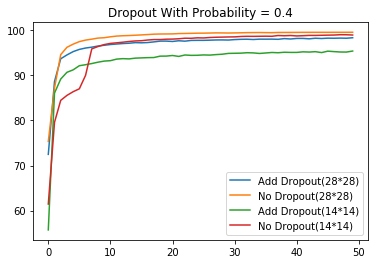

In [61]:
plt.plot(trace1,label='Add Dropout(28*28)')
plt.legend(loc='lower right')
plt.plot(trace2,label='No Dropout(28*28)')
plt.legend(loc='lower right')
plt.plot(trace3,label='Add Dropout(14*14)')
plt.legend(loc='lower right')
plt.plot(trace4,label='No Dropout(14*14)')
plt.legend(loc='lower right')
plt.title('Dropout With Probability = 0.4')
plt.savefig('dropoutwithP=0.4.png')

In [63]:
# save model
PATH = '.'
torch.save(model.state_dict(), PATH)
torch.save(model, PATH)

NameError: name 'model' is not defined